In [1]:
pip install pandas numpy nltk seaborn transformers torch xgboost scikit-learn matplotlib

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------------- ------------------- 0.8/1.5 MB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/10.0 MB 13.4 MB/s eta 0:00:01
   ------------- -------------------------- 3.4/10.0 MB 11.2 MB/s eta 0:00:01
   ------------------------------ --------- 7.6/10.0 MB 13.8 MB/s eta 0:00:01
   ---------------------------------------- 10.0/10.0 MB 13.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   -- ------------------------------------- 8.1/124.9 MB 50.1 MB/s eta 0:00:03
   --- --------------------------------

In [2]:
import os
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import BertTokenizer, BertModel
import torch
from sklearn.linear_model import LinearRegression

f:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set paths
DATA_PATH = os.path.join("data", "kc_house_data.csv")

# Load data
df = pd.read_csv(DATA_PATH)

In [6]:
# ==========================
# STEP 1: Preprocess Structured Data
# ==========================

# Handle missing values
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

num_cols = df.select_dtypes(include=["number"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Feature engineering
df["price_per_sqft"] = df["price"] / df["sqft_living"]

# Normalize numerical columns
num_cols = ["sqft_living", "sqft_lot", "sqft_above", "sqft_basement", "price_per_sqft"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# One-hot encode categorical features
categorical_cols = ["zipcode"]
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded = encoder.fit_transform(df[categorical_cols])
df = df.drop(columns=categorical_cols)
df = pd.concat([df, pd.DataFrame(encoded)], axis=1)

In [8]:
# ==========================
# STEP 2: Preprocess Textual Data
# ==========================

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))  # Remove special characters
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Assuming a 'description' column exists for property descriptions
if "description" in df.columns:
    df["description_clean"] = df["description"].apply(clean_text)

# Convert text to embeddings using BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def text_to_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state.mean(dim=1).numpy()

if "description_clean" in df.columns:
    df["text_embedding"] = df["description_clean"].apply(text_to_embedding)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\小迪同学\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
f:\Python\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\小迪同学\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warning

In [13]:
# ==========================
# STEP 3: Build Predictive Models
# ==========================

# Split Data
X = df.drop(columns=["price"])
y = df["price"]
for col in X.select_dtypes(include=["datetime64"]).columns:
    X[col] = X[col].astype(np.int64) // 10**9
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Train XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluate models
def evaluate(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:\n RMSE: {rmse}, MAE: {mae}, R²: {r2}\n")

evaluate(y_test, y_pred_rf, "Random Forest")
evaluate(y_test, y_pred_xgb, "XGBoost")

Random Forest Performance:
 RMSE: 66001.14793858971, MAE: 33789.050471894516, R²: 0.9711850359477967

XGBoost Performance:
 RMSE: 74865.36987794984, MAE: 39214.235155707844, R²: 0.9629253505828373



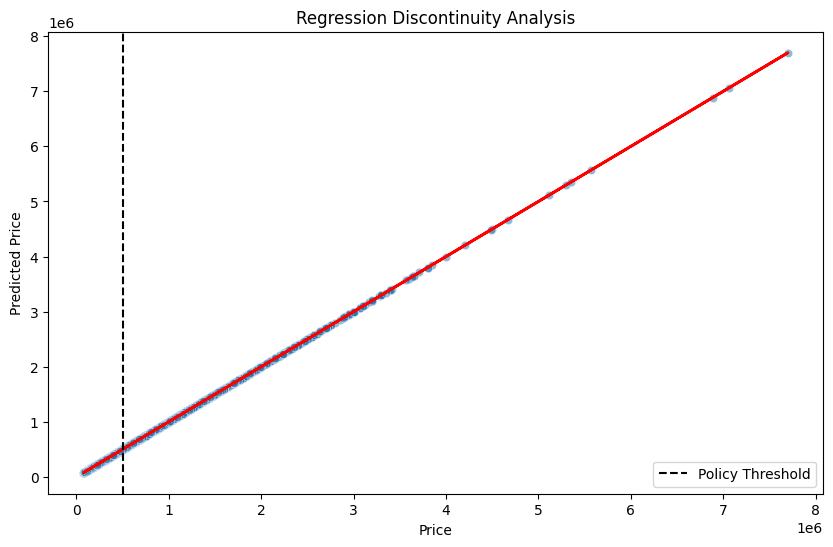

In [15]:
# ==========================
# STEP 4: Causal Inference (Regression Discontinuity)
# ==========================

df["treatment"] = (df["price"] >= 500000).astype(int)

rdd_model = LinearRegression()
rdd_model.fit(df[["price"]].values.reshape(-1, 1), df["price"])
df["predicted_price"] = rdd_model.predict(df[["price"]].values.reshape(-1, 1))

# Plot Regression Discontinuity
plt.figure(figsize=(10,6))
sns.scatterplot(x=df["price"], y=df["price"], alpha=0.5)
plt.plot(df["price"], df["predicted_price"], color="red", linewidth=2)
plt.axvline(x=500000, color="black", linestyle="--", label="Policy Threshold")
plt.xlabel("Price")
plt.ylabel("Predicted Price")
plt.title("Regression Discontinuity Analysis")
plt.legend()
plt.show()